In [0]:
import importlib

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
from tqdm import tqdm

In [0]:
class ModelFactory:
    """
    Model facotry for Keras default models
    """

    def __init__(self):
        self.models_ = dict(
            VGG16=dict(
                input_shape=(224, 224, 3),
                module_name="vgg16",
                last_conv_layer="block5_conv3",
            ),
            VGG19=dict(
                input_shape=(224, 224, 3),
                module_name="vgg19",
                last_conv_layer="block5_conv4",
            ),
            DenseNet121=dict(
                input_shape=(224, 224, 3),
                module_name="densenet",
                last_conv_layer="bn",
            ),
            ResNet50=dict(
                input_shape=(224, 224, 3),
                module_name="resnet50",
                last_conv_layer="activation_49",
            ),
            InceptionV3=dict(
                input_shape=(299, 299, 3),
                module_name="inception_v3",
                last_conv_layer="mixed10",
            ),
            InceptionResNetV2=dict(
                input_shape=(299, 299, 3),
                module_name="inception_resnet_v2",
                last_conv_layer="conv_7b_ac",
            ),
            NASNetMobile=dict(
                input_shape=(224, 224, 3),
                module_name="nasnet",
                last_conv_layer="activation_188",
            ),
            NASNetLarge=dict(
                input_shape=(331, 331, 3),
                module_name="nasnet",
                last_conv_layer="activation_260",
            ),
        )

    def get_last_conv_layer(self, model_name):
        return self.models_[model_name]["last_conv_layer"]

    def get_input_size(self, model_name):
        return self.models_[model_name]["input_shape"][:2]

    def get_model(self, class_names, model_name="DenseNet121", use_base_weights=True,
                  weights_path=None, input_shape=None):

        if use_base_weights is True:
            base_weights = "imagenet"
        else:
            base_weights = None

        base_model_class = getattr(
            importlib.import_module(
                f"tensorflow.keras.applications.{self.models_[model_name]['module_name']}"
            ),
            model_name)

        if input_shape is None:
            input_shape = self.models_[model_name]["input_shape"]

        img_input = Input(shape=input_shape)

        base_model = base_model_class(
            include_top=False,
            input_tensor=img_input,
            input_shape=input_shape,
            weights=base_weights,
            pooling="avg")
        x = base_model.output
        predictions = Dense(len(class_names), activation="sigmoid", name="predictions")(x)
        model = Model(inputs=img_input, outputs=predictions)

        if weights_path == "":
            weights_path = None

        if weights_path is not None:
            print(f"load model weights_path: {weights_path}")
            model.load_weights(weights_path)
        return model

In [0]:
class_names = ["Atelectasis",
"Cardiomegaly",
"Effusion",
"Infiltration",
"Mass",
"Nodule",
"Pneumonia",
"Pneumothorax",
"Consolidation",
"Edema",
"Emphysema",
"Fibrosis",
"Pleural_Thickening",
"Hernia"]

In [0]:
model_factory = ModelFactory()
model = model_factory.get_model(class_names)

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [0]:
from google.colab import drive

In [7]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir("drive/My Drive/Colab Notebooks/CheXNet")

In [0]:
model.load_weights("brucechou1983_CheXNet_Keras_0.3.0_weights.h5")

In [0]:
import numpy as np
import os
import pandas as pd
from tensorflow.keras.utils import Sequence
from PIL import Image
from skimage.transform import resize

In [0]:
target_size=(224, 224)

In [0]:
for layer in model.layers:
    layer.trainable = False

In [0]:
model.layers[-1].trainable = True

In [0]:
from tensorflow.keras.models import Model

model2 = Model(model.input, model.layers[-2].output)

In [0]:
layer_1 = Dense(120, activation="sigmoid", name="penultimo")(model2.output)

In [0]:
predictions = Dense(3, activation="softmax", name="predictions")(layer_1)

In [0]:
model2 = Model(inputs=model2.inputs, outputs=predictions)

In [18]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

In [0]:
target_size=(224, 224)

In [0]:
image_path = "Imagens/NORMAL/NORMAL (2).png"

In [0]:
def open_image(image_path):
    image = Image.open(image_path)
    image_array = np.asarray(image.convert("RGB"))
    image_array = image_array / 255.
    image_array = resize(image_array, target_size)
    return image_array

def transform_batch_images(batch_x):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    batch_x = (batch_x - imagenet_mean) / imagenet_std
    return batch_x

In [0]:
image_array = open_image(image_path)
image_array = transform_batch_images(image_array)
image_array = np.expand_dims(image_array, axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


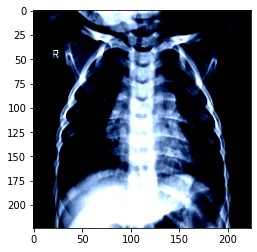

In [25]:
plt.imshow(image_array[0])

In [26]:
model.predict(image_array)

array([[2.4109508e-05, 5.8603655e-10, 1.8079627e-05, 1.2817431e-03,
        1.9135950e-06, 5.4589591e-06, 5.4367071e-09, 1.3279447e-07,
        1.4891592e-06, 4.7565984e-10, 2.3744420e-09, 2.0459368e-09,
        1.7942091e-07, 1.5320928e-17]], dtype=float32)

In [0]:
def read_images(direc):
  files = os.listdir(direc)
  images = []

  for file in tqdm(files):
    image_array = open_image(direc+file)
    image_array = transform_batch_images(image_array)
    images.append(image_array)

  return np.array(images)

In [28]:
images_covid = read_images("Imagens/COVID-19/")

100%|██████████| 219/219 [00:41<00:00,  5.32it/s]


In [29]:
images_normal = read_images("Imagens/NORMAL/")

100%|██████████| 1341/1341 [03:41<00:00,  6.06it/s]


In [30]:
images_pneu = read_images("Imagens/Viral Pneumonia/")

100%|██████████| 1345/1345 [04:10<00:00,  5.37it/s]


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train_covid, X_test_covid = train_test_split(images_covid, test_size=60, random_state=42)
X_train_normal, X_test_normal = train_test_split(images_normal, test_size=60, random_state=42)
X_train_pneu, X_test_pneu = train_test_split(images_pneu, test_size=60, random_state=42)

In [0]:
del images_covid, images_normal, images_pneu

In [0]:
y_train_covid = np.array([[[1,0,0]] * X_train_covid.shape[0]])
y_train_normal = np.array([[[0,1,0]] * X_train_normal.shape[0]])
y_train_pneu = np.array([[[0,0,1]] * X_train_pneu.shape[0]])

In [0]:
X = np.concatenate([X_train_covid, X_train_normal, X_train_pneu], axis=0)

In [0]:
y = np.concatenate([y_train_covid, y_train_normal, y_train_pneu], axis=1)

In [0]:
del X_train_covid, X_train_normal, X_train_pneu

In [0]:
y= y[0]

In [0]:
X_train, X_valid, y_train, y_valid,  = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

train_generator = gen.flow(X_train, y_train, batch_size=64)
test_generator = test_gen.flow(X_valid, y_valid, batch_size=64)

Using TensorFlow backend.


In [0]:
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

In [0]:
# optimizer = Adam(lr=0.01)
optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True, name="SGD")

In [0]:
model2.compile(optimizer=optimizer, loss="binary_crossentropy")

In [0]:
class_weight={0:8, 1:1, 2:1}

In [45]:
#model2.fit(train_generator, epochs=5, steps_per_epoch=32, validation_data=test_generator, validation_steps=4, class_weight=class_weight)

Epoch 1/5
32/32 [==============================] - 28s 879ms/step - loss: 0.8976 - val_loss: 0.5942
Epoch 2/5
32/32 [==============================] - 26s 814ms/step - loss: 0.8561 - val_loss: 0.6703
Epoch 3/5
32/32 [==============================] - 26s 809ms/step - loss: 0.8206 - val_loss: 0.5294
Epoch 4/5
32/32 [==============================] - 26s 803ms/step - loss: 0.7866 - val_loss: 0.4828
Epoch 5/5
32/32 [==============================] - 26s 809ms/step - loss: 0.7338 - val_loss: 0.4746


In [0]:
for i in range(10,100):
    print(i)
    model2.fit(train_generator, epochs=25, steps_per_epoch=32, validation_data=test_generator, validation_steps=8, class_weight=class_weight)
    model2.save("Rede_Covid_"+str(i)+".h5")

In [0]:
i=18
model2.save("TESTE_"+str(i)+".h5")

In [0]:
model2.load_weights("TESTE_18.h5")

In [0]:
predict_covid = model2.predict(X_test_covid)

In [60]:
pd.Series(np.argmax(predict_covid, axis=1)).value_counts()

0    56
2     2
1     2
dtype: int64

In [0]:
predict_normal = model2.predict(X_test_normal)

In [62]:
pd.Series(np.argmax(predict_normal, axis=1)).value_counts()

1    58
2     1
0     1
dtype: int64

In [0]:
predict_pneu = model2.predict(X_test_pneu)

In [64]:
pd.Series(np.argmax(predict_pneu, axis=1)).value_counts()

2    53
1     6
0     1
dtype: int64

In [84]:
y_train.sum(axis=0)

array([ 131, 1013, 1036])

In [85]:
y_valid.sum(axis=0)

array([ 28, 268, 249])

In [86]:
y_valid.sum(axis=0)/y_train.sum(axis=0)

array([0.21374046, 0.26456071, 0.24034749])